In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)

In [23]:
train = pd.read_csv('logistic_digits_train.txt')
test = pd.read_csv('logistic_digits_test.txt')
#Now, we remove spaces present within column names for easier analysis
train.columns = train.columns.str.replace(' ', '')
test.columns = test.columns.str.replace(' ', '')

In [24]:
def logit(train, weights, biases):
    logit_scores = (weights.dot(train.T).T) + biases[:,0]
    return logit_scores

In [36]:
def softmax(logit_matrix, output_nums):
    prob_dist = np.array([np.empty([output_nums]) for i in range(len(logit_matrix))])
    for i in range(len(logit_matrix)):
        logit_matrix[i] -= np.max(logit_matrix)
        x = np.exp(logit_matrix[i])
        prob_dist[i] = x/(np.sum(x))
    return prob_dist

In [37]:
def cross_entropy(probabilities, gt_classes, weights):
    prob_length = len(probabilities)
    lamb = 1/len(gt_classes)
    L2 = (weights.T.dot(weights))*lamb
    #L2norm = np.linalg.norm(weights)
    cross_entropy.log_likelihood = np.log(probabilities[np.arange(prob_length), gt_classes.squeeze(-1)])
    loss = cross_entropy.log_likelihood.sum() #+ ((L2norm)**2)/len(gt_classes) + L2 
    averaged_loss = loss/prob_length
    return averaged_loss


In [38]:
def sgd(train, gt_classes, weights,
        biases, step_size, output_nums,
        iterations):

    n = len(gt_classes)
    lamb = 1/n
    L2 = lamb * (weights.T.dot(weights))
    axis0 = np.arange(train.shape[0])
    cost_history = np.zeros(iterations)

    for x in range(iterations):

        cost = 0.0

        # update weight vector based on one datapoint at a time.

        for i in range(n):
            index = np.random.randint(0, n)
            
            data = train[index, :].reshape(1, -1)
            label = gt_classes[index]

            logitScores = logit(data, weights, biases)
            probs = softmax(logitScores, output_nums)

            cost = cost + cross_entropy(probs, gt_classes[index], weights)
            
            probs[0, label] -= 1

            # gradient of weights
            weight_grad = probs.T.dot(data) #+ L2
            bias_grad = np.sum(probs, axis=0).reshape(-1, 1)

            # update weights
            weights = weights - (step_size * weight_grad)

            # update biases
            biases = biases - (step_size * bias_grad)

            cost_history[x] = cost/n
            if x>1 and (cost_history[x-1] > cost_history[x]):
                step_size = step_size/10

    return weights, biases, cost_history



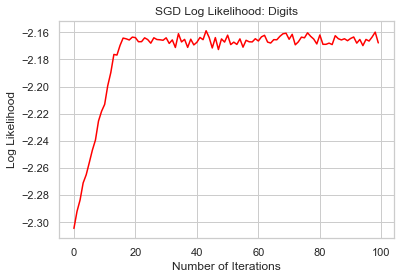

In [41]:
output_classes = len(np.unique(train['Var2'].values))
#n_cls_news = len(np.unique(train_news['Var2'].values))


features = train.shape[1] - 1
#n_feats_news = df_train_news.shape[1] - 1

step_size = 0.01
iterations = 100

weight_matr = np.random.rand(output_classes, features)
biases = np.random.rand(output_classes, 1)

# W_news = np.random.rand(n_cls_news, n_feats_news)
# biases_news = np.random.rand(n_cls_news, 1)

X = train.loc[:, :'X_train_65'].to_numpy()
y = train.loc[:, 'Var2'].to_numpy().reshape(-1, 1)

# X_news = df_train_news.loc[:, :'X_train_2001'].to_numpy()
# y_news = df_train_news.loc[:, 'Var2'].to_numpy().reshape(-1, 1)


X = X / 255.
#from sklearn import preprocessing
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)


weights, biases, log_likelihood = sgd(X, y, weight_matr, biases, step_size, output_classes, iterations)
#print(log_likelihood)
# W_news, biases_news, LL_news = sgd(X_news, y_news, W_news, biases_news, lr, n_cls_news, iterations)

# plot log likelihood
x = np.arange(iterations)
sns.set_style('whitegrid')
ax = sns.lineplot(x=x, y=log_likelihood, color = 'red')

ax.set_title("SGD Log Likelihood: Digits")
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Log Likelihood")
plt.show()


In [40]:
def predict(x_test, W, y, biases, n_cls):
    logit_scores = logit(x_test, W, biases)
    probs = softmax(logit_scores, n_cls)
    y_hat = np.argmax(probs, axis = 1).reshape(-1,1)
    accuracy = (y_hat == y).sum() / len(y) * 100
    return accuracy

# feature and label vectors
X_test = test.loc[:, :'X_test_65'].to_numpy()
y_test = test.loc[:, 'Var2'].to_numpy().reshape(-1, 1)


#X_test = X_test / 255
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)
output_nums=10
acc = predict(X_test, weights, y_test, biases, output_nums)

print(f"Digits accuracy: {acc:.2f}%")


Digits accuracy: 84.47%
